### Using hybrid layers of Convolution and Attention
This experiment was to do CIFAR-10 prediction using a model which includes hybrid layers of convolution and attention, yet couldn't push the accuracy beyond 91%

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T

import torch.nn.functional as F  # useful stateless functions
import numpy as np

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)


In [ ]:
# Import CIFAR-10 dataset

NUM_TRAIN = 49000
from torchvision import transforms

mean_val = [0.4914, 0.4822, 0.4465]
std_val = [0.2470, 0.2435, 0.2616]

# augmentation transforms 
random_transform1 = transforms.RandomHorizontalFlip(p=0.5) 
random_transform2 = transforms.Compose([transforms.Pad(padding=4),
                                        transforms.RandomCrop((32, 32))])

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_val,
                         std=std_val),
    transforms.RandomChoice([random_transform1, random_transform2]),

])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_val,
                         std=std_val),
])


cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=train_transform)

loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# A clip of small dataset to try out new models 
loader_temp = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(1000)))

cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=train_transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./datasets', train=False, download=True, 
                            transform=test_transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

In [ ]:
def check_accuracy_part34(loader, model):
    """
    Evaluates the model against the provided dataset for accuracy 
    """
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

def train_part34(model, optimizer, epochs=1, lr_decay=0.5, history=None, temp = False):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    if temp:
        loader = loader_temp
    else:
        loader = loader_train
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=lr_decay)
    if history is None:
        history = {"loss":[], "epoch":[], "acc_val":[], "lr":[]}
    last_loss = 9999999.0
    for e in range(epochs):
        current_loss = 0.0
        for t, (x, y) in enumerate(loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                acc_val = check_accuracy_part34(loader_val, model)
                print("lr:",scheduler.get_last_lr())
                print()
            current_loss+=loss.item()
        history["loss"].append(loss.item())
        history["epoch"].append(e)
        history["acc_val"].append(acc_val)
        history["lr"].append(scheduler.get_last_lr()[0])
        if last_loss <=current_loss:
            scheduler.step()
        last_loss = current_loss
        if scheduler.get_last_lr()[0] < 1e-5:
            return history
    return history


In [18]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)


class abs(torch.autograd.Function):
    """
    Absolute value activation function
    """
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input) # save input for backward pass

        return torch.abs(input)

    @staticmethod
    def backward(ctx, grad_output):

        input, = ctx.saved_tensors 
        
        return grad_output*torch.sign(input)

class ABS(nn.Module):
    """
    Absolute value activation layer
    """
    def __init__(self):
        super(ABS, self).__init__()
        self.prelu = nn.PReLU()
        self.abs = abs.apply

    def forward(self, x):
        x = self.abs(self.prelu(x))
        return x

            
class Unit(nn.Module):
    """
    Spatial layer with Conv-Pool-Self-Attention Module
    """
    def __init__(self, inf, outf, in_scale, conv_k, pool_k=3, conv_s=1, pool_s=2, act="ABS"):
        super().__init__()
        self.outf = outf
        self.in_scale = in_scale
        self.conv = nn.Conv2d(inf, outf, conv_k, padding=int((conv_k-1)/2), stride=conv_s)
        self.attention = nn.MultiheadAttention(in_scale**2, in_scale, batch_first=True)
        self.max_pool = nn.MaxPool2d(pool_k, stride=pool_s)
        self.act = get_act(act)
        self.bn = nn.BatchNorm2d(outf)
        
    def forward(self, x1, attention = False):
        pool = self.max_pool(self.conv(x1))
        if attention:
            pool_reshaped = torch.reshape(pool, (pool.shape[0], pool.shape[1], -1))
            attn, _ = self.attention(pool_reshaped, pool_reshaped, pool_reshaped, need_weights=False)
            attn_pool = pool_reshaped+attn

            attn_pool_norm = torch.nn.functional.normalize(attn_pool, p=2.0, dim = 2)
            out = torch.reshape(attn_pool_norm, (attn_pool_norm.shape[0], attn_pool_norm.shape[1], self.in_scale, self.in_scale))
            y = self.act(self.bn(out))
        else:
            y = self.act(self.bn(pool))
        return y

class ChannelPool(nn.Module):
    """
    Channel-wise max pooling
    """
    def forward(self, input):
        input_max, max_indices = torch.max(input, dim=1, keepdim=True)
        return input_max

class Scale(nn.Module):
    """
    Tensor spatial scalling layer
    """
    def __init__(self, size):
        super().__init__()
        self.size = size
    def forward(self, input):
        return torchvision.transforms.Resize(self.size)(input)
    
    
class LinearUnit(nn.Module):
    """
    Fully connceted layer with Linear-Batchnorm-Dropout-ReLU
    """
    def __init__(self, in_size, out_size):
        super().__init__()
        self.fc = nn.Linear(in_size, out_size)
        self.batchnorm = nn.BatchNorm1d(out_size)
        self.dropout = nn.Dropout(0.5)
        self.act = nn.ReLU()
    def forward(self, x):
        return self.act(self.dropout(self.batchnorm(self.fc(x))))



In [63]:
class Net(nn.Module):
    def __init__(self, act="ReLU"):
        super().__init__()
        self.u1 = Unit(3, 256, 15, conv_k=5, pool_k=3, conv_s=1, pool_s=2, act=act)
        self.u2 = Unit(256, 512, 6, conv_k=3, pool_k=3, conv_s=1, pool_s=2, act=act)
        self.u3 = Unit(512, 512, 6, conv_k=3, pool_k=3, conv_s=1, pool_s=2, act=act)
        self.u4 = Unit(512, 512, 6, conv_k=3, pool_k=3, conv_s=1, pool_s=2, act=act)
        
        self.l1 = LinearUnit(512, 512)
        self.l2 = LinearUnit(512, 128)
        self.fc_l = nn.Linear(128, 10)
        self.batchnorm_l = nn.BatchNorm1d(10)
        self.act_l = get_act(act)

    def forward(self, x):
        l1 = self.u1(x,True)
        l2 = self.u2(l1)
        l3 = self.u3(l2)
        l4 = self.u4(l3)
        
        fl = flatten(l4)
        l2 = self.l2(self.l1(fl))
        scores = self.act_l(self.batchnorm_l(self.fc_l(l2)))

        return scores


def test_Net():
    x = torch.rand((64, 3, 32, 32), dtype=dtype)*5  # minibatch size 64, image size [3, 32, 32]
    model = Net()
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print("Params:",pytorch_total_params)
test_Net()

torch.Size([64, 10])
Params: 6473110


In [64]:
model = Net()
history = {"loss":[], "epoch":[], "acc_val":[], "lr":[]}
optimizer= optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
t = time.time()
hostory = train_part34(model, optimizer, 1000, 0.1, history, False)
print((time.time()-t)/60)

Iteration 0, loss = 2.5823
Checking accuracy on validation set
Got 112 / 1000 correct (11.20)
lr: [0.001]

Iteration 100, loss = 1.9028
Checking accuracy on validation set
Got 333 / 1000 correct (33.30)
lr: [0.001]

Iteration 200, loss = 1.7027
Checking accuracy on validation set
Got 445 / 1000 correct (44.50)
lr: [0.001]

Iteration 300, loss = 1.5567
Checking accuracy on validation set
Got 468 / 1000 correct (46.80)
lr: [0.001]

Iteration 400, loss = 1.4365
Checking accuracy on validation set
Got 515 / 1000 correct (51.50)
lr: [0.001]

Iteration 500, loss = 1.5555
Checking accuracy on validation set
Got 599 / 1000 correct (59.90)
lr: [0.001]

Iteration 600, loss = 1.1650
Checking accuracy on validation set
Got 610 / 1000 correct (61.00)
lr: [0.001]

Iteration 700, loss = 1.1913
Checking accuracy on validation set
Got 640 / 1000 correct (64.00)
lr: [0.001]

Iteration 0, loss = 0.8971
Checking accuracy on validation set
Got 645 / 1000 correct (64.50)
lr: [0.001]

Iteration 100, loss = 1

In [65]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print("Params:",pytorch_total_params)
check_accuracy_part34(loader_test, model)  

Params: 6473110
Checking accuracy on test set
Got 9094 / 10000 correct (90.94)


0.9094

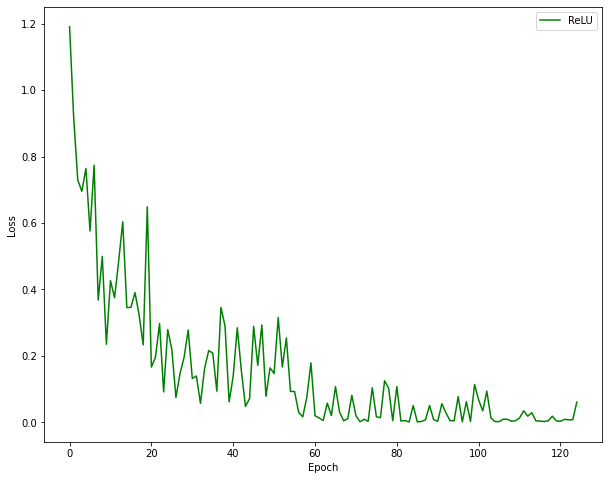

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"


plt.plot(history["epoch"], history["loss"], 'g-')
plt.legend(["ReLU"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();